# WWTP inflow dataset: Horsens

In [81]:
import folium

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import abspath
from IPython.display import display, HTML
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

from darts import TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality, ModelMode
from darts.utils.missing_values import fill_missing_values, extract_subseries

In [82]:
# Define the coordinates for Horsens Municipality
horsens_coords = [55.8607, 9.8502]  # Approximate center of Horsens Municipality
dmi_station_coords = [55.868, 9.7872]
wwtp_coords = [55.85512, 9.85414]

m = folium.Map(location=horsens_coords, zoom_start=12)

folium.Marker(
    dmi_station_coords,
    popup="weather station",
    tooltip="DMI station",
    icon=folium.Icon(icon="cloud", color="green"),
).add_to(m)
folium.Marker([55.8540, 9.8600], popup="WWTP", tooltip="WWTP").add_to(m)

display(
    HTML(
        """
    <div style="width: 50%; height: 50%; margin: auto;">
        """
        + m._repr_html_()
        + """
    </div>
"""
    )
)

## Loading data

In [83]:
path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"

inflow = pd.read_csv(abspath(path_to_inflow), parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize(
    "Europe/Copenhagen", ambiguous="NaT"
).tz_convert("utc")

DMI always provides data in UTC (https://opendatadocs.dmi.govcloud.dk/en/Data/Climate_Data)

In [84]:
climate = pd.read_csv(abspath(path_to_dmi_data), parse_dates=True, index_col=0, sep=",")
climate.index = climate.index.tz_localize("utc")

In [85]:
data = inflow.merge(climate, left_index=True, right_index=True, how="outer").iloc[:-1]
data.index = data.index.tz_convert(None)

## Gaps

There are some instances of measureming a flow that is exactly 0, I count that as nan. Similarly, values that are very close are also counted as nan.

In [86]:
threshold_flow = 2
data[data["flow"] < threshold_flow] = np.nan

Also, there are periods that are a flat line, we consider those nans as well

In [87]:
def find_flat_periods(series: pd.Series, min_span_length: int, min_delta: float):
    """
    Find periods where the value of the series does not change at least `min_delta` within `min_span_length` steps.

    Returns:
    List of tuples: Each tuple contains the start and end index of a stable period.
    """
    stable_periods = []
    start_idx = None

    for i in range(len(series) - 1):
        if abs(series.iloc[i + 1] - series.iloc[i]) < min_delta:
            if start_idx is None:
                start_idx = i
        else:
            if start_idx is not None and i - start_idx > min_span_length:
                stable_periods.append((start_idx, i - 1))
            start_idx = None

    # Capture any ongoing stable period at the end
    if start_idx is not None:
        stable_periods.append((start_idx, len(series) - 1))

    return stable_periods


period_length = 6  # hours
min_delta = 5  # flow
stable_periods = find_flat_periods(
    data["flow"], min_span_length=period_length, min_delta=min_delta
)
stable_idx = [l for idx in stable_periods for l in list(range(*idx))]

data.loc[data.index[stable_idx], "flow"] = np.nan

In [88]:
ts = TimeSeries.from_dataframe(data, freq="h", fill_missing_dates=False)
ts = fill_missing_values(ts, method="linear", limit=3, limit_area="inside")

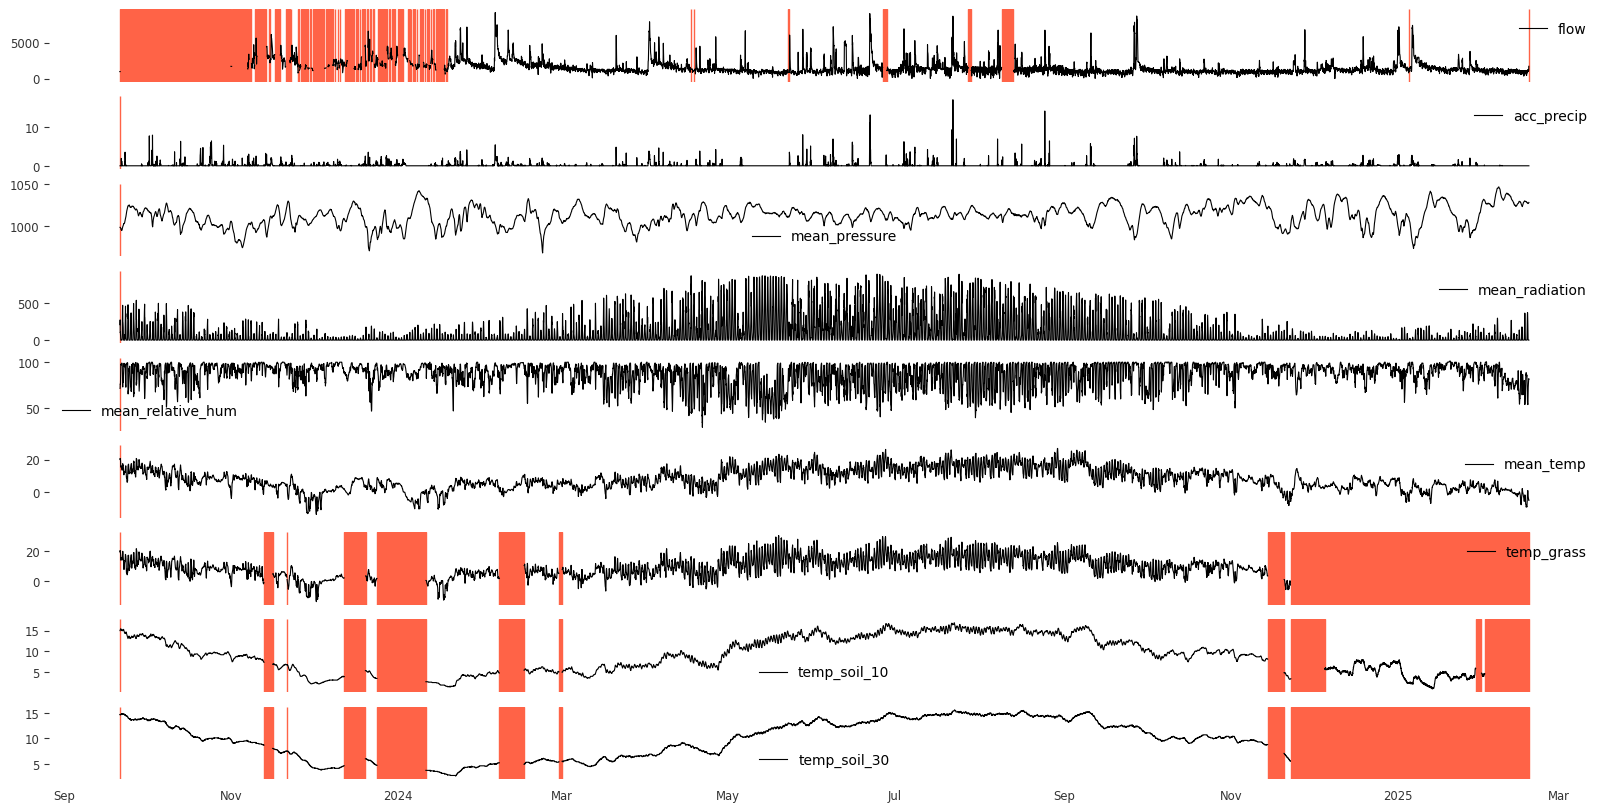

In [89]:
fig, axes = plt.subplots(ts.n_components, 1, figsize=(20, 10), sharex="col")

for i, component in enumerate(ts.components):
    gaps = ts[component].gaps(mode="any")
    ts[component].plot(ax=axes[i], linewidth=0.8)
    for _, row in gaps.iterrows():
        axes[i].axvspan(xmin=row["gap_start"], xmax=row["gap_end"], color="tomato")
    axes[i].grid(visible=False)
    axes[i].set_xlabel("")

- Saving data after merging

In [90]:
ts.to_csv("../processed/data.csv")

## Trends

(Each trend line corresponds to one continuouts subseries)


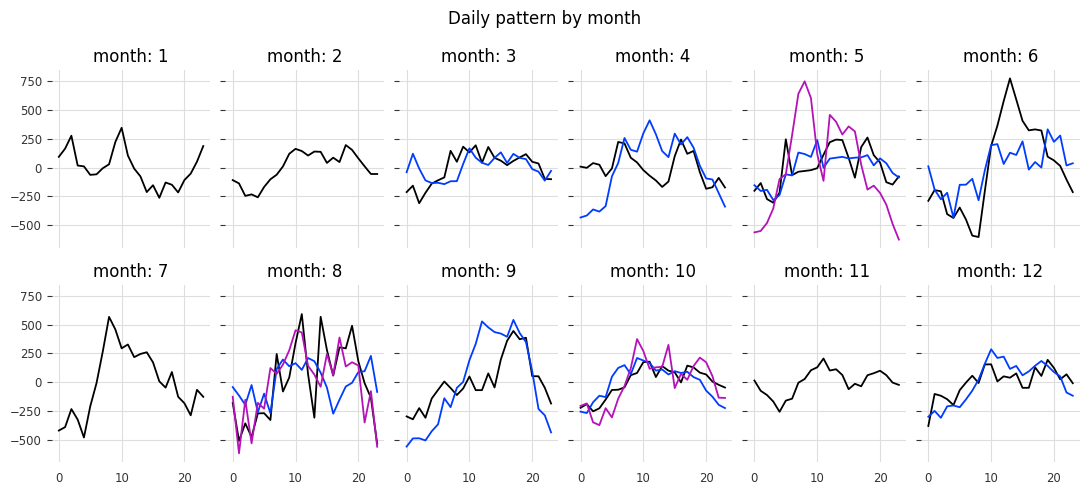

In [91]:
df = data[["flow"]].copy()
df = df.loc[df.index.year == 2024, :].copy()

ncols = 6
fig, axes = plt.subplots(2, ncols, sharex=True, sharey=True, figsize=(11, 5))

month = 1
for i, month in enumerate(range(1, 13)):
    df_i = df.loc[df.index.month == month, :]
    df_i.index = df_i.index.tz_localize(
        None
    )  # this is done to avoid a warning message from darts
    ts_i = TimeSeries.from_dataframe(df_i, freq="h")
    subseries = extract_subseries(ts_i)
    for ssi in subseries:
        if len(ssi) > 72:
            trend_i, seasonality_i = extract_trend_and_seasonality(
                ssi, freq=24, model=ModelMode.ADDITIVE
            )
            daily_pattern = (
                seasonality_i.to_dataframe()
                .groupby(seasonality_i.time_index.hour)
                .mean()
            )

            row = i // ncols
            col = i - row * ncols
            axes[row, col].plot(daily_pattern.index, daily_pattern.values.ravel())
            axes[row, col].set_title(f"month: {month}")

plt.suptitle("Daily pattern by month")
plt.tight_layout()

print("(Each trend line corresponds to one continuouts subseries)")

## Correlations

In [92]:
def lp_filter(x: np.array, alpha: float) -> np.array:
    # https://empslocal.ex.ac.uk/people/staff/dbs202/cag/courses/MT37C/course/node102.html
    y = np.zeros_like(x)
    y[0] = x[0]

    for t in range(1, len(x)):
        y[t] = alpha * x[t] + (1 - alpha) * y[t - 1]

    return y

In [93]:
def f(x: float, ts: TimeSeries, lag: int):
    time_index = ts.time_index
    filtered_precip = pd.Series(
        lp_filter(ts["acc_precip"].values().ravel(), x), index=time_index
    )
    x1 = filtered_precip.shift(lag).dropna()
    x2 = ts["flow"].to_series().loc[x1.index]

    return -np.abs(pearsonr(x1.values, x2.values).statistic)


ts = TimeSeries.from_dataframe(
    data[["flow", "acc_precip"]].apply(np.log1p), freq="h"
).longest_contiguous_slice(mode="any")


for lag in [0, 1, 2, 3, 4]:
    res = minimize_scalar(f, bounds=(1e-5, 0.9999), args=(ts, lag))
    print(lag, round(res.fun, 3), round(res.x, 3))

0 -0.79 0.019
1 -0.768 0.018
2 -0.745 0.017
3 -0.724 0.016
4 -0.704 0.016


<Axes: xlabel='time'>

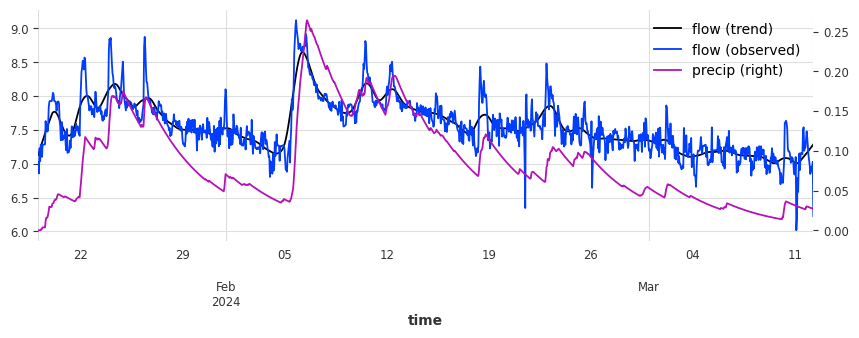

In [94]:
trend, seasonality = extract_trend_and_seasonality(
    ts["flow"], model=ModelMode.ADDITIVE, method="STL"
)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
pd.DataFrame(
    {
        "flow (trend)": trend.values().ravel(),
        "flow (observed)": ts["flow"].values().ravel(),
        "precip": lp_filter(ts["acc_precip"].values().ravel(), 0.01),
    },
    index=ts.time_index,
).plot(ax=ax, secondary_y="precip")

We would like to compare the correlation with data from the summer. We can look for the longest subseries that contains summer dates:

In [104]:
df = data.loc[:, ["flow", "acc_precip", "mean_temp", "mean_radiation"]].copy()
for col in ["flow", "acc_precip"]:
    df[col] = df[col].map(np.log1p)

subseries = extract_subseries(
    TimeSeries.from_dataframe(
        df,
        freq="h",
    ),
    mode="any",
)

subseries = [ssi for ssi in subseries if len(ssi) > 24 * 14]

results = []
for i, ssi in enumerate(subseries):
    # We only optimize for periods with different precipitation measurements
    if len(set(ssi["acc_precip"].values().ravel())) > 1:
        mean_temp = ssi["mean_temp"].to_series().mean()
        mean_radiation = ssi["mean_radiation"].to_series().mean()

        res = minimize_scalar(f, bounds=(1e-3, 0.999), args=(ssi, 0))

        results.append((res.x, mean_temp, mean_radiation))

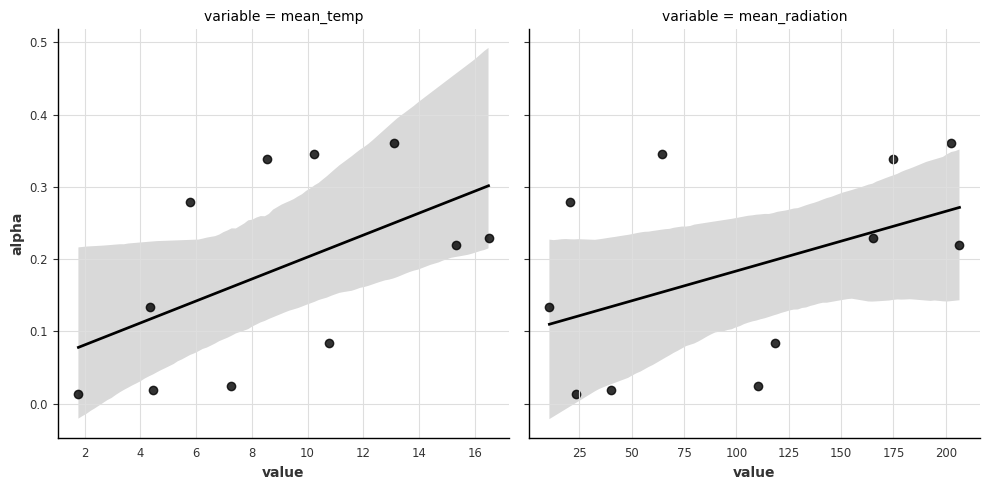

In [101]:
datplot = pd.DataFrame(results, columns=["alpha", "mean_temp", "mean_radiation"]).melt(
    id_vars="alpha"
)
sns.lmplot(
    datplot, x="value", y="alpha", col="variable", order=1, facet_kws=dict(sharex=False)
);